In [2]:
import numpy as np
import jhu2016_labs.plotting as plotting
import jhu2016_labs.models as models

%matplotlib inline

## Training data 

In real scenario, we  observed a set of values, often called features, and we try to learn some model that can "explain" the observed features. Generally, we do not know the true distribution of the features. For this work we will simulate a set of single dimensional features sampled from a GMM. We will call this GMM the "true model" and in this notebook we will see different strategies to approximate the true model from the simulated training data.    

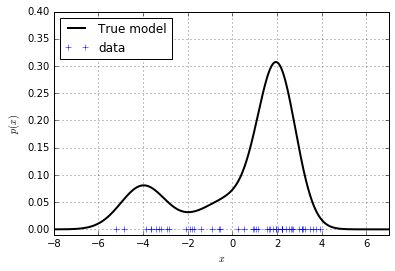

In [3]:
true_model = models.GMM([-4, 0, 2], [1, 2, .7], [0.2, 0.2, 0.6])
X = true_model.sampleData(50)
Y = np.zeros_like(X) # The random variable has a single dimension !
x_min = -8
x_max = 7
y_min = -0.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, 
                           label='True model')
ax.plot(X, Y, '+', color='b', label='data')
ax.legend(loc='upper left')

## Gaussian density 

We can first try to model the observed data with a Gaussian density function. The Gaussian density function is defined as:
$$
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\Gam}{Gam}
\DeclareMathOperator{\e}{exp}
p(x \mid \mu, \sigma^2) = \Norm(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \e\{ \frac{-(x - \mu)^2}{2\sigma^2} \}
$$
* $\mu$ is the **mean** of the Gaussian density 
* $\sigma^2$ is the **variance** of the Gaussian density


##### TODO
Try to play with the mean and the variance of the Gaussian. How each parameter change the density ?

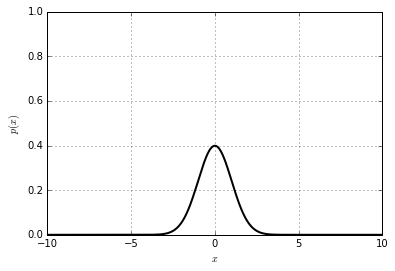

In [4]:
gaussian = models.Gaussian(0., 1.) # <- 1st parameter is mean, second variance0
fig, ax = plotting.plotGaussian(gaussian)

Alternatively, the Gaussian density function can be parameterized with a precision $\lambda$ which is the inverse of the variance:
$$
    \DeclareMathOperator{\e}{exp}
    p(x | \mu, \lambda) = \Norm(x \mid \mu, \lambda^{-1}) = \frac{\sqrt{\lambda}}{\sqrt{2\pi}} \e\{ \frac{-\lambda(x - \mu)^2}{2} \}
$$
* $\mu$ is the **mean** of the Gaussian density 
* $\lambda = \frac{1}{\sigma^2}$ is the **precision** of the Gaussian density

This alternative parameterization will prove to be useful when dealing with Bayesian inference for the Gaussian/GMM density.

### Maximum Likelihood estimation

We will first try to model our data with a simple Gaussian. We need to find the parameters (mean and variance) that fit the best the data. 

$$
\begin{align}
\mu &= \frac{1}{N} \sum_i x_i \\
\sigma^2 &= \frac{1}{N} \sum_i x_i^2
\end{align}
$$

##### TODO
From the above equations, implement the maximum-likelihood solution for the Gaussian. Does the Gaussian seems to be a good model for the true density ?

correct solution !
('log-likelihood:', -118.67558132954579)


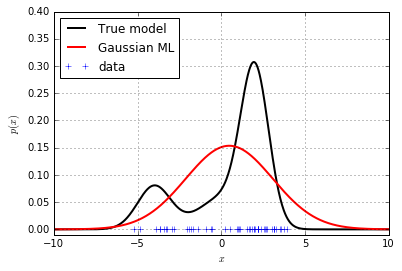

In [5]:
##########################
# Write your code here. 
mean_ml = np.mean(X)
var_ml = np.mean(np.square(X-mean_ml))
##########################

# Check your solutions uncomment the following code
test_gaussian_ml = models.Gaussian.maximumLikelihood(X)
assert np.isclose(test_gaussian_ml.mean, mean_ml), 'incorrect mean'
#assert np.isclose(test_gaussian_ml.var, var_ml), 'incorrect variance'
print('correct solution !')
gaussian_ml = models.Gaussian(mean_ml, var_ml)
llh = gaussian_ml.logLikelihood(X)
print('log-likelihood:', llh)

y_min = -.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, y_min=y_min, y_max=y_max, label='True model')
plotting.plotGaussian(gaussian_ml, fig=fig, ax=ax, color='red', label='Gaussian ML')
ax.plot(X, Y, '+', color='b', label='data')
ax.legend(loc='upper left')

### Bayesian Inference

We can work within the Bayesian framework with the Gaussian density by putting a prior over the mean and precision. A common an convenient choice of prior for the Gaussian is the **Normal-Gamma** prior:

$$
p(\mu, \lambda \mid m_0, \kappa_0, a_0, b_0) = \Norm(\mu \mid m_0, (\kappa_0 \lambda)^{-1}) \Gam(\lambda \mid a_0, b_0)
$$

where:

$$
\Gam(\lambda \mid a_0, b_0) = \frac{1}{\Gamma(a_0)} b_0^{a_0} \lambda^{a_0 - 1} \e \{ -b_0 \lambda\}
$$

$m_0$, $\kappa_0$, $a_0$ and $b_0$ are called **hyper-parameters**. They are the parameters of the prior distribution.

##### TODO
Play with the parameters of the Normal-Gamma. How each parameter affects the density ?

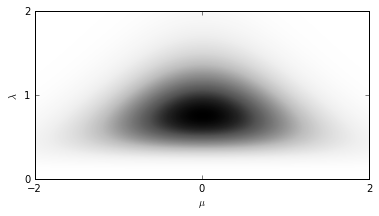

In [6]:
ng_prior = models.NormalGamma(0, 2, 5, 6)
x_min =-2.
x_max = 2.
y_min = 0.
y_max = 2
plotting.plotNormalGamma(ng_prior, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

Because the Normal-Gamma is the **conjugate prior** of the Normal density, the posterior distribution $p(\mu, \lambda \mid \mathbf{x})$ has a closed form solution:

$$
p(\mu, \lambda \mid \mathbf{x}) = \Norm(\mu \mid m_n, (\kappa_n \lambda)^{-1}) \Gam(\lambda \mid a_n, b_n)
$$

where:

$$
\begin{align}
m_n &= \frac{\kappa_0 m_0 + N \bar{x}} {\kappa_0 +  N} \\
\kappa_n &= \kappa_0 + N \\
a_n &= a_0 + \frac{N}{2} \\
b_n &= b_0 + \frac{N}{2} ( s + \frac{\kappa_0 (\bar{x} - m_0)^2}{\kappa_0 + N} ) \\
\bar{x} &= \frac{1}{N} \sum_i x_i \\
s &= \frac{1}{N} \sum_i (x_i - \bar{x})^2
\end{align}
$$

$N$ is the total number of point in the the training data and $m_n$, $\kappa_n$, $a_n$ and $b_n$ are the parameters of the posterior. Note that they are different from the hyper-parameters !! 

##### TODO
Compute the posterior distribution with 1, 5, 10, 20 and 50  data points from the training data. What do you observe ?

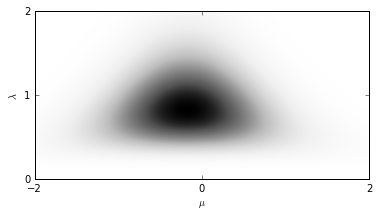

In [7]:
ng_prior = models.NormalGamma(0, 2, 5, 6)
ng_posterior = ng_prior.posterior(X[:1]) # <- Change '1' to the number of sample you want to use 
x_min =-2
x_max = 2
y_min = 0.
y_max = 2
plotting.plotNormalGamma(ng_posterior, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

### Predictive probability

Now that we have our posterior distibution we can predict the probability of a new data point given the training data:

$$
p(x' \mid \mathbf{x}) = \int p(x' \mid \theta) p(\theta \mid \mathbf{x}) d \theta
$$

For the Gaussian with Normal-Gamma prior the marginal predictive distribution is the Student's t distribution:

$$
\newcommand{\diff}{\mathop{}\!d}
\DeclareMathOperator{\St}{\mathcal{St}}
p(x' \mid \mathbf{x}) = \int_{-\infty}^{\infty} p(x|\mu, \lambda) p(\mu, \lambda \mid \mathbf{x}) \diff \mu \diff \lambda  = \St(x' \mid \mu_n, \nu, \gamma)
$$

where:

$$
\begin{align}
\nu &= 2a_n \\
\gamma &= \frac{a_n \kappa_n}{b_n(\kappa_n + 1)} \\
\St(x' \mid \mu_n, \nu, \gamma) &= \frac{\Gamma(\frac{\nu}{2} + \frac{1}{2})}{\Gamma(\frac{\nu}{2})} \Big( \frac{\gamma}{\pi \nu} \Big)^{\frac{1}{2}} \Big[ 1 + \frac{\gamma (x - \mu_n)^2}{\nu} \Big]^{-\frac{\nu}{2} - \frac{1}{2}}
\end{align}
$$

##### TODO
Compute the log-likelihood of the predictive distribution derived from a posterior trained with 1, 5, 10, 20  and 50 data points. How does it compare to the log-likelihood of the Gaussian trained with maximum likelihood ?

In [8]:
ng_posterior = ng_prior.posterior(X[:1]) # <- Change '1' by the number of sample you want to use.
predict_pdf = ng_posterior.predictiveDensity()  
llh = predict_pdf.logLikelihood(X)
print('log-likelihood:', llh)

('log-likelihood:', -158.86113265330383)


## Gaussian Mixture Model (GMM)

The Gaussian density is a very simple function, however, in most cases of interest the density we try to model has a complex shape that cannot be expressed with a simple formula. A solution is to assume that our complex density is made of $K$ Gaussian densities. This is called a Gaussian Mixture Model (GMM) and it is defined as:
$$
    p(x|\boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi}) = \sum_{k=1}^{K} \pi_k \Norm(x|\mu_k, (\lambda_k)^{-1})
$$
* $\boldsymbol{\mu}$ is the vector of $K$ means
* $\boldsymbol{\lambda}$ is the vector of $K$ precisions
* $\boldsymbol{\pi}$ is the vector of $K$ weights such that $\sum_{k=1}^K \pi_k = 1$ 

##### TODO
Observe the influence of each parameters on the density and add/remove some components. Does this model suffer of the same drawbacks of the Gaussian density ?

(<matplotlib.figure.Figure at 0x7f0648f4fd50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f064906e9d0>)

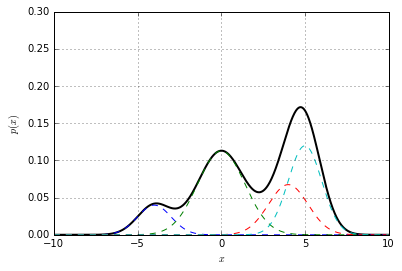

In [9]:
# Change the initial values of the parameters. 
# you can add a component by removing a mean, a variance 
# and a weight. All arrays shall always have the same number 
# of elements ! Be careful, make sure that the sum of weight 
# always sum up to one.
means = [-4.0, 0.0, 4.0, 5]
variances = [1.0, 2.0, 1.4, 1]
weights = [0.1, 0.4, 0.2, 0.3]
gmm = models.GMM(means, variances, weights)

y_min = 0.
y_max = .3
plotting.plotGMM(gmm, show_components=True, y_min=y_min, y_max=y_max)

## Maximum Likelihood estimation

The GMM parameters can be estimated with the **Expectation-Maximization** (EM) algorithm. The EM algorithm is an iterative algorithm that converges toward a (local) maximum of the log-likelihood of the data given the model. The EM training is as follows:
* initialize the parameters of the GMM 
* iterate until convergence:
    * Expectation (E-step): compute the probability of the latent variable for each data point
    * Maximization (M-step): update the parameters from the statistics of the E-step. 

##### TODO
* We have implemented a simple version of the EM algorithm that iterates 10 times. Change the following code to iterates until convergence of the log-likelihood. We will consider that the log-liklihood has converged if $ \log p(\mathbf{x} | \theta^{new}) - \log p(\mathbf{x} | \theta^{old}) \le 0.01$. 
* Run the EM algorithm with different initialization: is the final log-likelihood always the same ? What can you conclude ? Is the log-likelihood greater than the one from the Gaussian estimated with Maximum-Likelihood ?

('initial log-likelihood:', -133.8484539899051)
('log-likelihood:', -108.21311769470283)
('log-likelihood:', -107.12663821205872)
('log-likelihood:', -106.67414630445364)
('log-likelihood:', -106.4350065709144)
('log-likelihood:', -106.28566693721305)
('log-likelihood:', -106.18034211821832)
('log-likelihood:', -106.09991381080697)
('log-likelihood:', -106.03551557221053)
('log-likelihood:', -105.98254453779474)
('log-likelihood:', -105.93831290851898)


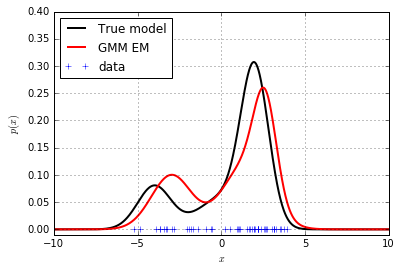

In [10]:
# Initialization of the model
means = [-4.0, 0.0, 4.0]
variances = [1.0, 1.0, 1.]
weights = [0.3, 0.4, 0.3]
gmm = models.GMM(means, variances, weights)

## EM algorithm
print('initial log-likelihood:', gmm.logLikelihood(X))
############################################
# Change this loop to check the convergence of the EM .
for i in range(10):
    # E-step
    Z = gmm.EStep(X)
    
    # M-step
    gmm.MStep(X, Z)
    
    llh = gmm.logLikelihood(X)
    print('log-likelihood:', llh)
##############################################

y_min = -0.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, y_min=y_min, y_max=y_max, label='True model')
plotting.plotGMM(gmm, fig=fig, ax=ax, color='r', label='GMM EM')
ax.plot(X, Y, '+', color='b', label='data')
ax.legend(loc='upper left')

## Bayesian GMM

We can also work the Bayesian inference for GMM by putting a prior over the GMM parameters. Let $\Theta$ be the set of parameters of the GMM:
$$
\Theta = \{ \boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi} \}
$$

The prior over the weights $\boldsymbol{\pi}$ will be a Dirichlet distribution:

$$
\DeclareMathOperator{\Dir}{Dir}
p(\boldsymbol{\pi}) = \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}_0)
$$

and the prior of the mean and precision of the component $k$ of the mixture will be a Normal-Gamma distribution:

$$
p(\mu_k, \lambda_k) = \Norm(\mu_k \mid m_0, (\kappa_0 \lambda_k)^{-1}) \Gam(\lambda_k \mid a_0, b_0)
$$

The joint distribution of the data, the latent variables and the parameters can be written as:

$$
\begin{align}
p(\mathbf{x}, \mathbf{z}, \Theta) &= p(\mathbf{x}, \mathbf{z} \mid \Theta)p(\Theta) \\
                      &= \Bigg[ \prod_{i=0}^{N} p(x_i \mid \boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi}) \Bigg] \Bigg[ \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}_0) \prod_{k=0}^{K} \Norm(\mu_k \mid m_0, (\kappa_0 \lambda_k)^{-1}) \Gam(\lambda_k \mid a_0, b_0) \Bigg]
\end{align}
$$


-173.88106025 15.8545589981 -189.735619248 inf
-66.4450783974 14.0837227786 -80.528801176 109.206818072
-65.1504228586 13.0838451256 -78.2342679841 2.29453319187
-64.8308670417 12.6709581851 -77.5018252268 0.732442757338
-64.6937479939 12.4843067448 -77.1780547387 0.323770488117


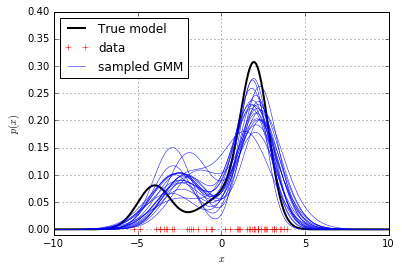

In [43]:
# hyper-parameters [pi_1, pi_2, ...], m, kappa, a, b
# you may try to change this.
import jhu2016_labs.var_models as var_models
reload(var_models)

bgmm = var_models.VarBayesGMM([1, 1, 1], 0, 1, 1, 1)

y_min = -0.01
y_max = .4
fig, ax = plotting.plotGMM(true_model, y_min=y_min, y_max=y_max, label='True model')

lower_bound = -float('Inf')

for i in range(5):
    resp, ev_llh, (Nk, xk_bar, Sk) = bgmm.EStep(X)
    
    kl_div = bgmm.KLPosteriorPrior()
    old_lower_bound, lower_bound = lower_bound, ev_llh - kl_div
    
    bgmm.MStep(X, (Nk, xk_bar, Sk))
    
    print ev_llh, kl_div, lower_bound, lower_bound - old_lower_bound
    
for i in range(20):
    plotting.plotGMM(bgmm.sample_gmm(), show_components=False, fig=fig, ax=ax, color='b', lw=.5, label='sampled GMM')
    
#gmm_avg = bgmm.averageGMM()
#plotting.plotGMM(gmm_avg, fig=fig, ax=ax, color='r', lw=3, label='average GMM')
ax.plot(X, Y, '+', color='r', label='data')
handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, loc='upper left')